In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os 
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
# Load the Data
data_dir = "Cat_Dog_data/" # or the path where you have downloaded the dataset


# Define the Transforms
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transform)    

# Create the DataLoader
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

In [3]:
# Helper Function for Viewing Image
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


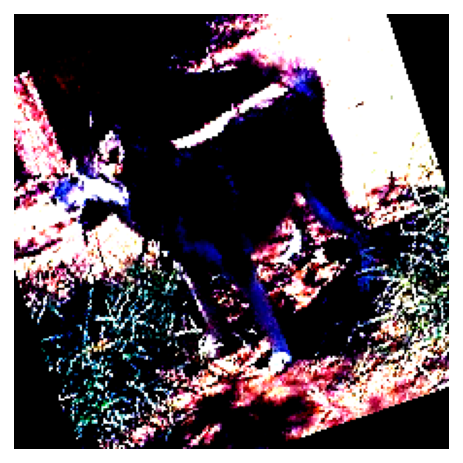

In [4]:
# Run this to test your data loaders
images, labels = next(iter(trainloader))
imshow(images[0])

In [5]:
model = models.densenet121(pretrained=True)

In [6]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 40)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(40, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))
    
model.classifier = classifier

In [7]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Change the classifier to make it work with your binary classification problem

model.classifier = nn.Sequential(nn.Linear(1024, 40),
                                 nn.ReLU(),
                                 nn.Linear(40, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
max_accuracy = 0
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # write the training loop. call the loss "loss" so that the line below will work

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            # REMEMBER TO ACTIVATE THE EVAL MODE
            model.eval()
            # ...
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    output = model(inputs)
                    batch_loss = criterion(output, labels)
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy

                    # Returns a new tensor with exponential elements of the output
                    ps = torch.exp(output)
                    # Returns the largest element for the given input, Get the top class of the output
                    top_p, top_class = ps.topk(1, dim=1)
                    # See how many of the classes were correct?
                    equals = top_class == labels.view(*top_class.shape)
                    # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    if accuracy >= max_accuracy:
                        max_accuracy = accuracy
                        torch.save(model.state_dict(), 'checkpoint.pth')
                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            # REMEMBER TO REACTIVATE THE TRAIN MODE
            model.train()

Epoch 1/1.. Train loss: 0.388.. Test loss: 0.182.. Test accuracy: 0.979
Epoch 1/1.. Train loss: 0.287.. Test loss: 0.411.. Test accuracy: 0.781
Epoch 1/1.. Train loss: 0.514.. Test loss: 0.183.. Test accuracy: 0.941
Epoch 1/1.. Train loss: 0.478.. Test loss: 0.106.. Test accuracy: 0.976
Epoch 1/1.. Train loss: 0.261.. Test loss: 0.184.. Test accuracy: 0.925
Epoch 1/1.. Train loss: 0.249.. Test loss: 0.159.. Test accuracy: 0.942
Epoch 1/1.. Train loss: 0.271.. Test loss: 0.123.. Test accuracy: 0.954
Epoch 1/1.. Train loss: 0.127.. Test loss: 0.093.. Test accuracy: 0.965
Epoch 1/1.. Train loss: 0.349.. Test loss: 0.145.. Test accuracy: 0.943
Epoch 1/1.. Train loss: 0.256.. Test loss: 0.129.. Test accuracy: 0.950
Epoch 1/1.. Train loss: 0.108.. Test loss: 0.081.. Test accuracy: 0.976
Epoch 1/1.. Train loss: 0.173.. Test loss: 0.085.. Test accuracy: 0.975
Epoch 1/1.. Train loss: 0.156.. Test loss: 0.092.. Test accuracy: 0.970
Epoch 1/1.. Train loss: 0.195.. Test loss: 0.090.. Test accuracy